## Notebook 3: Mountain Ranges

In this notebook we will try to combine mountains into mountain ranges (and individual river basins into watersheds).

In prior notebooks we determined what the mountains are by looking at the highest paths in elevation.
However, that gives us loads of peaks, and its unfortunately hard to get meaning from that.

Rather, we can group mountains that seem to be part of the same generally mass, a mountain range.

In [1]:
## Import Statements
import numpy as np
import matplotlib.pyplot as plt
from src.map_image import *
from src.map_instance import *
from src.map_data import *
from src.map_transforms import *

%config InlineBackend.figure_format = 'retina'

# Parameters
dataset = 'TBI'
region='hawaii'
minutes_per_node = 1
image_folder = 'img/03/'

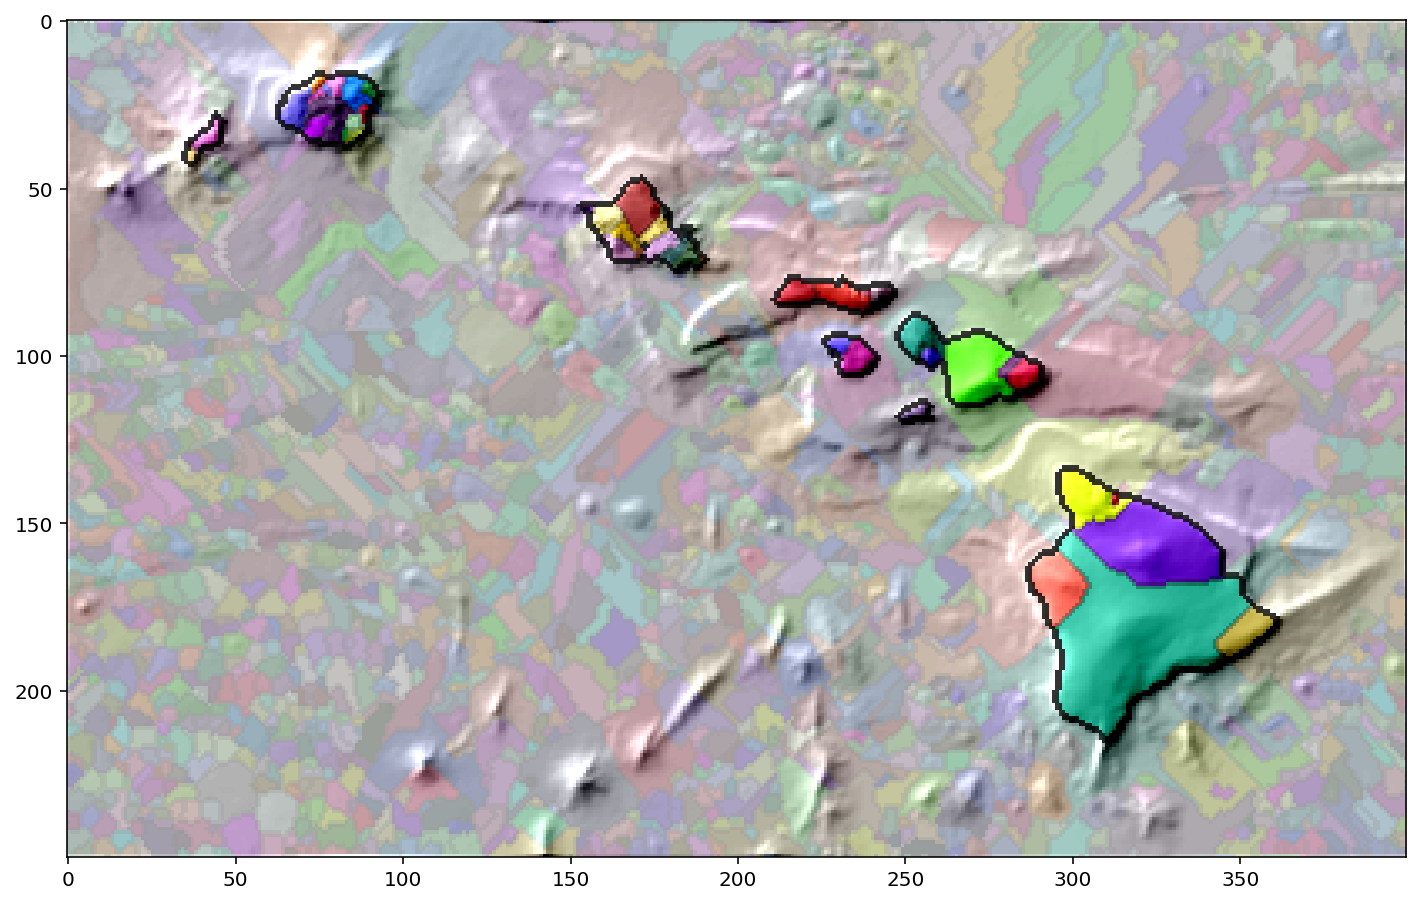

In [2]:
# Regenerate Elevation

map_elevation = loadRegionMap(region=region, dataset=dataset, minutes_per_node=minutes_per_node, image_folder=image_folder)
map_elevation_display = None
nodes_elevation_display = np.power(np.abs(map_elevation.getDataFlat() * 1.0), 0.5) * np.sign(map_elevation.getDataFlat())
nodes_elevation_display = nodes_elevation_display / max(nodes_elevation_display)
map_elevation_display = map_elevation.newChildInstance(
    {'values': 'elevation', 'mods': 'sqrt'}, 
    nodes_elevation_display
)
map_hillshade = getHillshade(map_elevation, 1)
map_landsea = map_elevation.newChildInstance(
    {'values': 'landmask'},
    map_elevation.getDataFlat() < 0,
)
map_landsea_border = getBorder(map_landsea, 1)

# Mountains
map_highest_neighbor_index = getHighestNeighbor(map_elevation)
map_mountain = getLocalPeaks(map_highest_neighbor_index)
map_mountain_border = getBorder(map_mountain, 1)
RasterImage(map_elevation) \
    .addLayer('base', 1) \
    .addLayer('mountain_border', 0.7, nodes_selected=map_mountain_border.getDataFlat()) \
    .addLayer('mountain', map_mountain.getDataFlat(), colormap='hashed', transforms=['norm'], combine='multiply', opacity=0.5) \
    .addLayer('sea', 1.2, nodes_selected=map_elevation.getDataFlat() < 0, combine='add', dissolve=.2) \
    .addLayer('hillshade', map_hillshade.getDataFlat(), combine='add', opacity=1, dissolve=1) \
    .addLayer('coast', .2, nodes_selected=map_landsea_border.getDataFlat(), combine='multiply') \
    .display().overrideLayerNames(['mountains']).final()

In [3]:
# Compute Neighbors / Adjacency List (useful for some algorithms)
#
# While some algorithms work well on linear arithmetic -- some are too hard to handle en masse
# Rather, we can compute the adjacency list and utilize that in algorithms
nodes_neighbors = getNodesNeighbors(map_elevation.getNumRows(), map_elevation.getNumCols(), 4, wrap=False)

## Algorithm 1

In order to determine mountain ranges, we will iterate through the mountains themselves.
Starting at the lowest mountains -- find the border node to the highest other mountain and associate that.
This will build chains of mountains / mountain ranges (mntrange).

From early investigation though, it does not appear quite right.
In the Hawaii map, if we stop the merging right before the last few peaks (20 left to go) we can see wide swatches of the ocean floor pointing to unexpected places.
There's a ridge west of Hawaii that is part of the Kauai range and part that is in the Molokai range -- why the split?
I think going from the lowest mountain peak to the highest is causing this problem, making changes of low peaks by coincedence, not intention.

### Asymptotic Analysis

n = # of nodes
m = # of mountains (probably n^0.5 or logn, but depends on the data)
r = # of nodes in mountain range (starts n/m but eventually tends to n)
e = # of neighbors (basically constant since it's 4 or 8, does not scale w/ map size

While there certainly are optimizations done by numpy, let's first estimate the efficiency assuming all array lookups and all transforms on arrays cost the size of the array.

* sort peaks O(m * logm)
* for each mountain, O(m)
  * find nodes in mountain range O(n)
  * for each node in mountain range O(r)
     * for neighbors of this node O(e) -- basically O(1)
        * lookup values, mnt ranges... O(1)
  * assign nodes in this mountain range to the taller one O(r)
  
Thereby, it looks like O(m*logm + m*r*e), which worst case maxes out at O(n^2), surprisingly not bad.
We could potentially speed it up by decreasing work in the loop for the mountain range -- if we keep track of what nodes are border nodes versus inner nodes (and thereby don't need to be checked) -- but it would only save the neighbor checks.

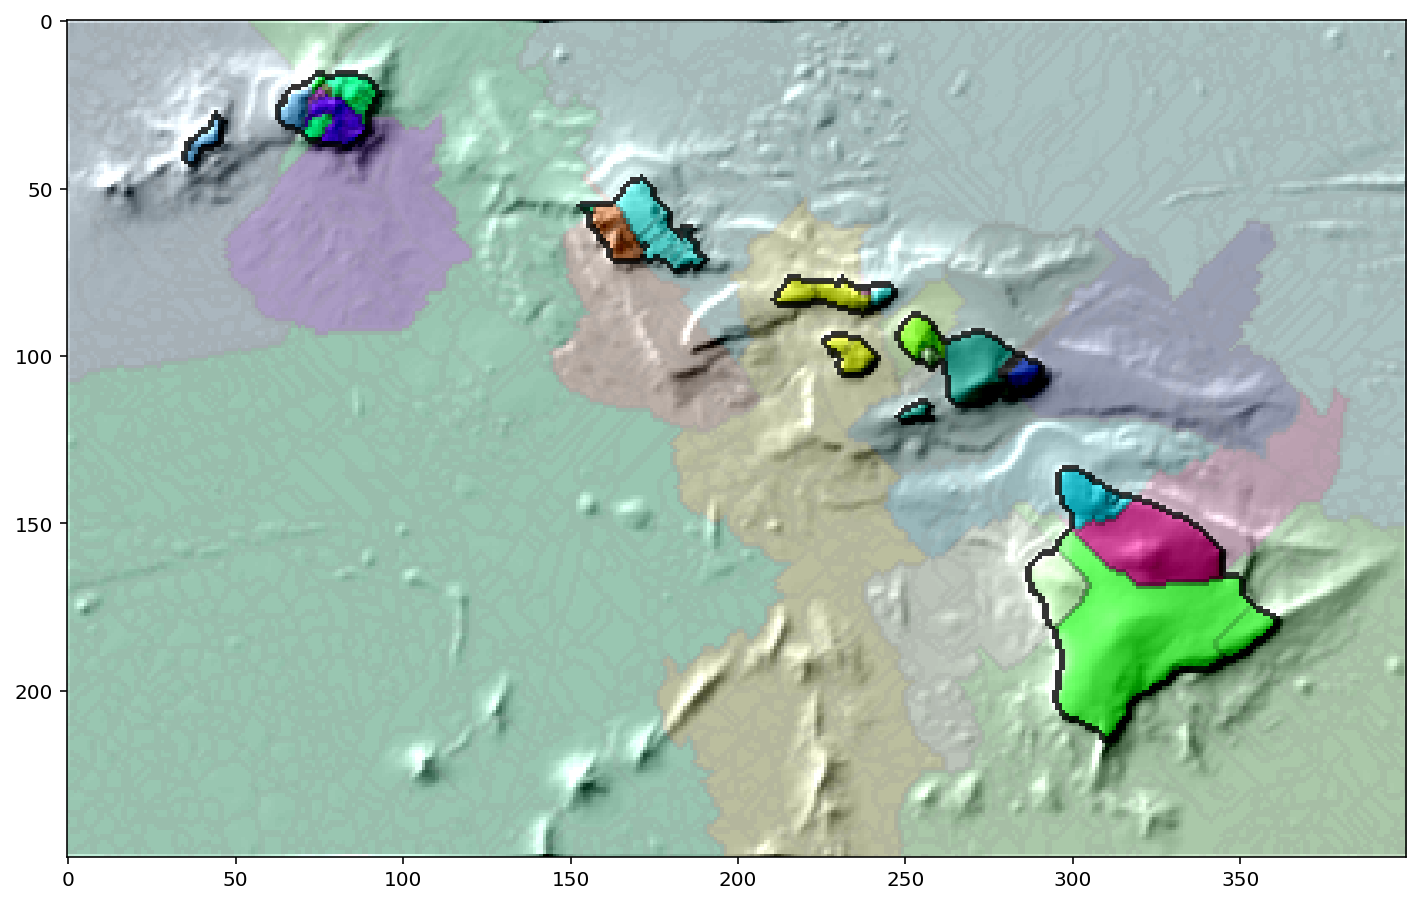

In [4]:
# in order to combine mountains into mountain ranges
# let's find the border of the mountain
# find the highest point outside of that border, and consider that the output of the mountain

nodes_mountain = map_mountain.getDataFlat()
peaks_index = np.unique(nodes_mountain)
peaks_mntrange = np.full(peaks_index.shape, -1)
peaks_ridge_node_in = np.full(peaks_index.shape, -1)
peaks_ridge_node_out = np.full(peaks_index.shape, -1)

nodes_mntrange = map_mountain.getDataFlat()

nodes_value = map_elevation.getDataFlat()
peaks_value = nodes_value[peaks_index]
i_sorted_peaks = np.argsort(peaks_value)

for i_peak in i_sorted_peaks[:-20]:
    peak_index = peaks_index[i_peak]
    mntrange_nodes = np.array(np.where(nodes_mntrange == peak_index)).flatten()

    # Search for the highest node outside of the mountain and consider that edge the "ridge"
    mountain_index = peak_index
    ridge_node_in = -1
    ridge_node_in_value = -1e6
    ridge_node_out = -1
    ridge_node_out_value = -1e6

    for mountain_node_index in mntrange_nodes:
        mountain_node_value = nodes_value[mountain_node_index]
        for neighbor_index in nodes_neighbors[mountain_node_index,:]:
            # Exclude not wrapping neighbors and neighbors that are already in the same mountain
            if (neighbor_index == -1 or nodes_mntrange[neighbor_index] == mountain_index):
                continue

            # If the neighboring node is the highest neighbor found so far and the mountain node value is the highest
            # Consider it the best possible ridge candidate
            neighbor_value = nodes_value[mountain_node_value]
            if (neighbor_value > ridge_node_out_value and mountain_node_value > ridge_node_in_value):
                ridge_node_in = mountain_node_index
                ridge_node_in_value = mountain_node_value
                ridge_node_out = neighbor_index
                ridge_node_out_value = neighbor_value
    
    # Mark this as the ridge out and mark this other peak as the parent peak
    mntrange = nodes_mntrange[ridge_node_out]
    peaks_mntrange[i_peak] = mntrange
    peaks_ridge_node_in[i_peak] = ridge_node_in
    peaks_ridge_node_out[i_peak] = ridge_node_out
    
    # if(nodes_value[mntrange] > nodes_value[mountain_index]):
    # if(ridge_node_out_value < 0):
    nodes_mntrange[mntrange_nodes] = mntrange


# Draw the map
map_mntrange = map_mountain.newChildInstance({'values': 'mntrange'}, nodes_mntrange)
map_mntrange_border = getBorder(map_mntrange, 1)

RasterImage(map_elevation) \
    .addLayer('base', 1) \
    .addLayer('mountain_border', 0.8, nodes_selected=map_mountain_border.getDataFlat()) \
    .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
    .addLayer('mntrange', map_mntrange.getDataFlat(), colormap='hashed', combine='multiply', opacity=0.5) \
    .addLayer('sea', 1.2, nodes_selected=map_elevation.getDataFlat() < 0, combine='add', dissolve=.2) \
    .addLayer('hillshade', map_hillshade.getDataFlat(), combine='add', opacity=1, dissolve=1) \
    .addLayer('coast', 0.2, nodes_selected=map_landsea_border.getDataFlat(), combine='multiply') \
    .display().overrideLayerNames(['mountain_range_algo1_holdout20peakmerges']).save().final()


## Algorithm 2

This tries a different algorithm instead -- instead we iterate over every node.
I'm not a fan of going over every node (doing it per mountain is better) -- but we had to go over every node in the prior algorithm anyway so perhaps this is more efficient.

The idea is that we are reconstructing the mountains from the high values to the lower ones -- which should keep ridges w/ small gaps together better than before.


### Asymptotic Analysis

n = # of nodes
m = # of mountains (probably n^0.5 or logn, but depends on the data)
r = # of nodes in mountain range (starts n/m but eventually tends to n)

* sort all nodes O(n * logn)
* for all nodes O(n)
   * for all neighbors O(e)
      * lookups, comparisons, and assignment
      * merge two regions O(n)

Thereby, this algorithm has at most a O(n * n * e) runtime -- but since we only expect to have m merges and e is effectively constant, it's closer to O(n * m)


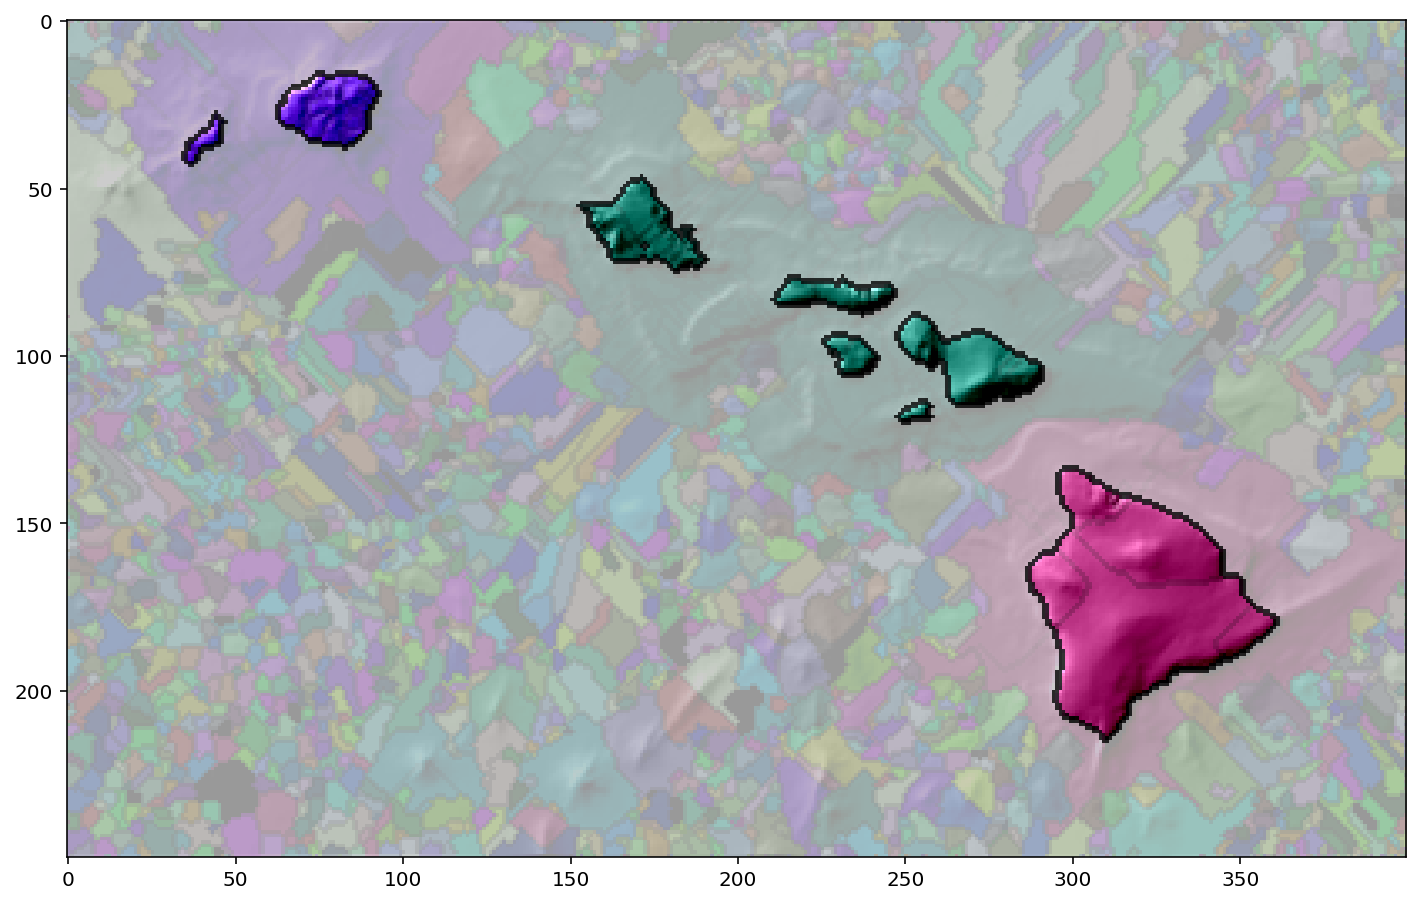

In [5]:
# Hmmm, that combined map does not look right
# Maybe, instead of going by peaks, we should go by nodes

nodes_mountain = map_mountain.getDataFlat()
nodes_mntrange = map_mountain.getDataFlat()
mountains_index = np.unique(nodes_mountain)
merges_lo_ridge_node = np.zeros(mountains_index.shape) - 1
merges_hi_ridge_node = np.zeros(mountains_index.shape) - 1
merges_lo_mntrange = np.zeros(mountains_index.shape) - 1
merges_hi_mntrange = np.zeros(mountains_index.shape) - 1
num_merges = 0

for explorer_index in np.argsort(-nodes_value)[:map_mountain.getNumNodes()//8]:
    node_value = nodes_value[explorer_index]
    explorer_mntrange = nodes_mntrange[explorer_index]
    
    for neighbor_index in nodes_neighbors[explorer_index,:]:
        # Exclude not wrapping neighbors and neighbors that are already in the same mountain
        if (neighbor_index == -1 or nodes_mntrange[neighbor_index] == explorer_mntrange):
            continue
        
        # They are different!
        neighbor_mntrange = nodes_mntrange[neighbor_index]
        # print ('merge ranges',node_mntrange, neighbor_mntrange)
        # print ('at',explorer_index, neighbor_index)
        
        if (nodes_value[explorer_mntrange] > nodes_value[neighbor_mntrange]):
            # The node's mountain range is taller, merge into that
            nodes_mntrange[nodes_mntrange == neighbor_mntrange] = explorer_mntrange
            
            # Record merge
            merges_lo_ridge_node[num_merges] = neighbor_index
            merges_hi_ridge_node[num_merges] = explorer_index
            merges_lo_mntrange[num_merges] = neighbor_mntrange
            merges_hi_mntrange[num_merges] = explorer_mntrange
            num_merges += 1
        else:
            # The neighbor's mountain peak is taller, merge into that
            nodes_mntrange[nodes_mntrange == explorer_mntrange] = neighbor_mntrange
            
            # Record merge
            merges_lo_ridge_node[num_merges] = explorer_index
            merges_hi_ridge_node[num_merges] = neighbor_index
            merges_lo_mntrange[num_merges] = explorer_mntrange
            merges_hi_mntrange[num_merges] = neighbor_mntrange
            num_merges += 1
            
            # Cleanup
            explorer_mntrange = neighbor_mntrange
            
# Draw the map
map_mntrange = map_mountain.newChildInstance({'values': 'parent_peak'}, nodes_mntrange)
map_mntrange_border = getBorder(map_mntrange, 1)
RasterImage(map_elevation) \
    .addLayer('base', 1) \
    .addLayer('mountain_border', 0.8, nodes_selected=map_mountain_border.getDataFlat()) \
    .addLayer('mntrange_border', 0.8, nodes_selected=map_mntrange_border.getDataFlat(), combine='multiply') \
    .addLayer('mntrange', map_mntrange.getDataFlat(), colormap='hashed', combine='multiply', opacity=0.5) \
    .addLayer('hillshade', map_hillshade.getDataFlat(), combine='add', opacity=1, dissolve=1) \
    .addLayer('sea', 1.2, nodes_selected=map_elevation.getDataFlat() < 0, combine='add', dissolve=.2) \
    .addLayer('coast', 0.2, nodes_selected=map_landsea_border.getDataFlat(), combine='multiply') \
    .display().overrideLayerNames(['mountain_range_algo2_eighththrough']).save().final()
    